In [1]:
import pandas as pd
#1~9호선 전체역별 모델을 제작하고자 하였으나 지하철 승하차 데이터에 전체역이 나와있지 않아 2019년 5월 기준 가장 많은 승하차 인원 top4와
#추가적으로 서울의 대표적 나들이 장소와 가까운 역 4군데를 선정하였다. 이태원 같은 경우는 코로나 확진으로 많은 피해를 받는 구이기 때문에
#포함시켜보았다.
import seaborn as sns
import matplotlib
import matplotlib.dates as md
import matplotlib.pyplot as plt
from datetime import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib 
from sklearn.metrics import make_scorer

# 시계열
from fbprophet import Prophet
from datetime import datetime as dt
from statsmodels.tsa.arima_model import ARIMA
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [5]:
#한글
!apt-get install fonts-nanum*
!apt-get install fontconfig
!fc-cache -fv
!cp /usr/share/fonts/truetype/nanum/Nanum* /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/
!rm -rf /content/.cache/matplotlib/*

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'fonts-nanum-eco' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-gothic-light' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-coding' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-extra' for glob 'fonts-nanum*'
The following NEW packages will be installed:
  fonts-nanum fonts-nanum-coding fonts-nanum-eco fonts-nanum-extra
0 upgraded, 4 newly installed, 0 to remove and 32 not upgraded.
Need to get 37.0 MB of archives.
After this operation, 145 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum-eco all 1.000-6 [14.0 MB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum-extra all 20170925-1 [12.2 MB]
Get:4 http://archive.ubu

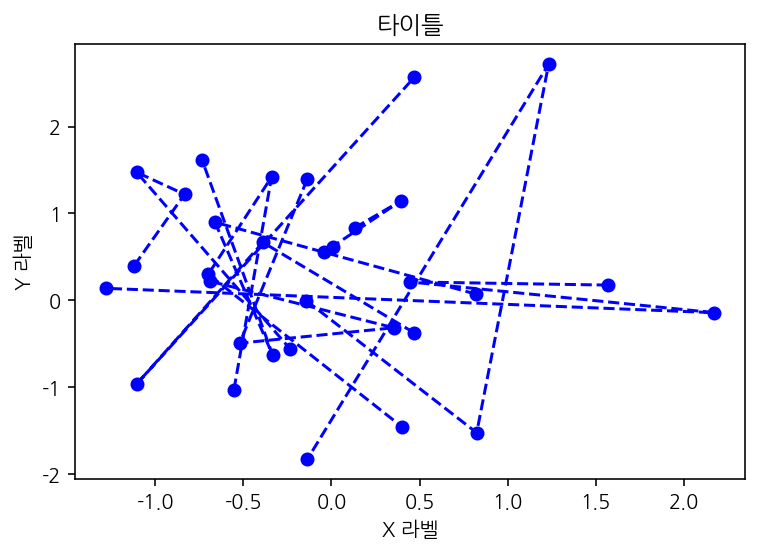

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
	
mpl.rcParams['axes.unicode_minus'] = False
# 그래프에서 마이너스 폰트 깨질 경우 대비
	
path = '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf'
font_name = fm.FontProperties(fname=path, size=18).get_name()
plt.rc('font', family=font_name)
fm._rebuild() # 이걸 해줘야 plt.rc가 작동

plt.plot(np.random.randn(4, 8), np.random.randn(4,8), 'bo--')
plt.title('타이틀')
plt.xlabel('X 라벨')
plt.ylabel('Y 라벨')
plt.show()
	

In [0]:
from fbprophet.plot import plot_plotly
import plotly.offline as py

In [54]:
def mae(prediction, correct):
    prediction = np.array(prediction)
    correct = np.array(correct)
    
    difference = correct - prediction
    abs_val = abs(difference)
    
    score = abs_val.mean()
    
    return score

mae_scorer = make_scorer(mae)
mae_scorer

make_scorer(mae)

In [57]:
weather_add_covid = pd.read_csv('wether_metro_covid.csv',encoding='CP949')
#weather_add_1
weather_add_covid['일시'] = pd.to_datetime(weather_add_covid['일시'], format='%Y-%m-%d', errors='raise')
weather_add_covid

,일시,평균기온(°C),일강수량(mm),평균 풍속(m/s),노선명,역명,승하차인원,휴일여부,confirmed
0,2019-01-01,-3.7,0.0,1.8,2호선,1,75273,1,0
1,2019-01-02,-3.5,0.0,1.5,2호선,1,233032,0,0
2,2019-01-03,-1.9,0.0,1.1,2호선,1,245143,0,0
3,2019-01-04,-0.5,0.0,1.3,2호선,1,264826,1,0
4,2019-01-05,-1.5,0.0,2.0,2호선,1,185844,1,0
...,...,...,...,...,...,...,...,...,...
4027,2020-05-14,20.9,0.0,0.4,5호선,8,19958,0,29
4028,2020-05-15,16.9,9.0,0.8,5호선,8,13201,1,27
4029,2020-05-16,17.0,1.5,0.6,5호선,8,11312,1,19
4030,2020-05-17,19.2,0.0,0.7,5호선,8,14847,1,13


In [21]:
weather_mean = weather_add_covid.groupby('일시',sort=True)[['승하차인원']].mean()
weather_mean = weather_mean.reset_index()
weather_mean

,일시,승하차인원
0,2019-01-01,68514.125
1,2019-01-02,110251.250
2,2019-01-03,114547.250
3,2019-01-04,126606.000
4,2019-01-05,114071.750
...,...,...
499,2020-05-14,72553.500
500,2020-05-15,73730.125
501,2020-05-16,56527.000
502,2020-05-17,41353.750


In [22]:
mean_prophet = pd.DataFrame({'ds' : weather_mean.일시, 'y' : weather_mean.승하차인원}).reset_index(drop=True)
mean_prophet

,ds,y
0,2019-01-01,68514.125
1,2019-01-02,110251.250
2,2019-01-03,114547.250
3,2019-01-04,126606.000
4,2019-01-05,114071.750
...,...,...
499,2020-05-14,72553.500
500,2020-05-15,73730.125
501,2020-05-16,56527.000
502,2020-05-17,41353.750


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


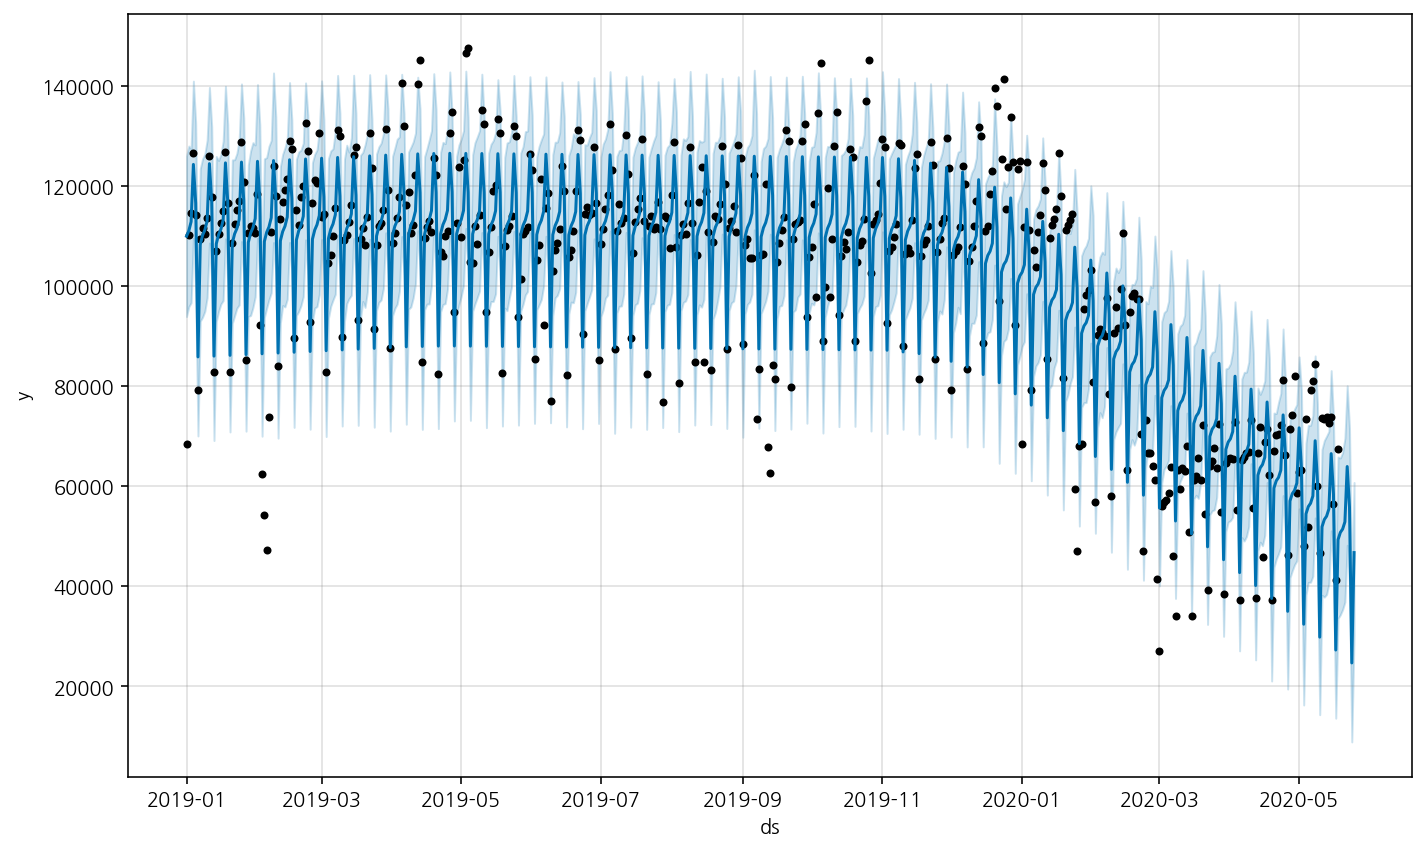

In [23]:
prophet_model = Prophet() # 예측값에 상한과 하한을 두지 않을 것이기 때문에 'logistic' 등을 사용하지 않고 default인 'linear' 사용
prophet_model.fit(mean_prophet)
future = prophet_model.make_future_dataframe(periods=7)
forecast = prophet_model.predict(future)
fig1 = prophet_model.plot(forecast)

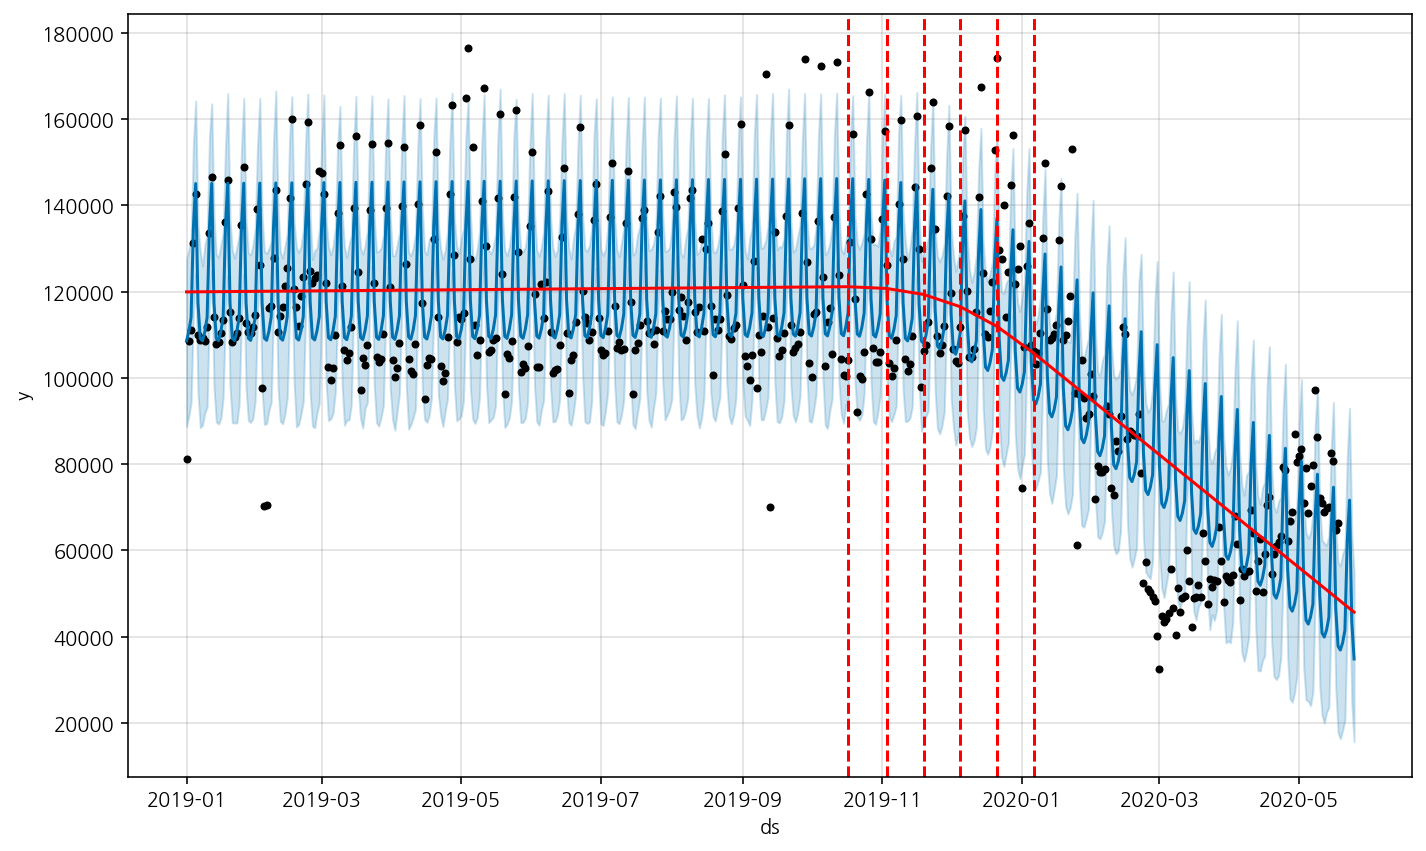

In [52]:
from fbprophet.plot import add_changepoints_to_plot
fig = prophet_model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet_model, forecast)
fig.savefig('prophet_trend변화시점.png')

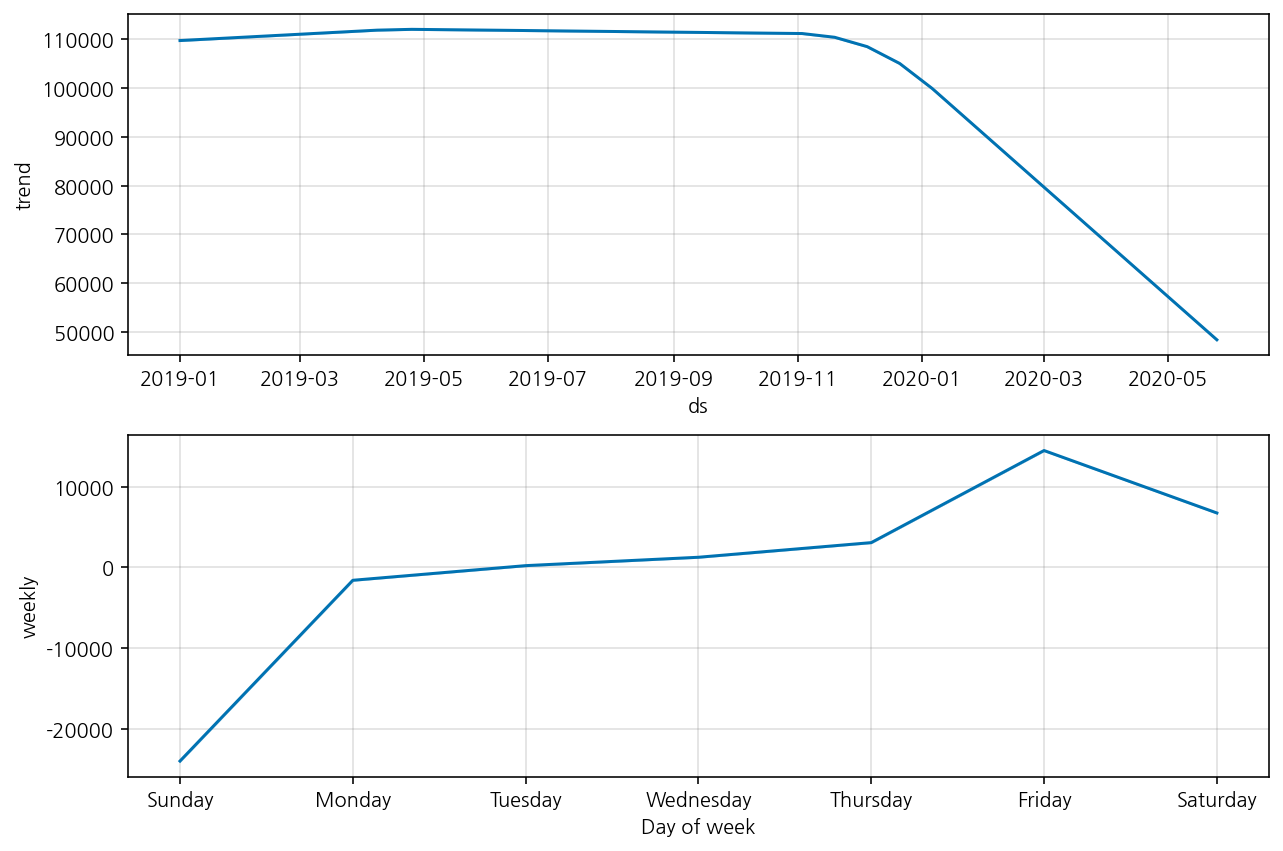

In [24]:
fig2 = prophet_model.plot_components(forecast)

In [44]:
#Facebook Prophet

df_set = weather_add_covid[weather_add_covid.역명 == 2]
df_prophet = pd.DataFrame({'ds' : df_set.일시, 'y' : df_set.승하차인원}).reset_index(drop=True)
df_prophet

,ds,y
0,2019-01-01,81143
1,2019-01-02,108547
2,2019-01-03,111173
3,2019-01-04,131287
4,2019-01-05,142740
...,...,...
499,2020-05-14,70149
500,2020-05-15,82554
501,2020-05-16,80678
502,2020-05-17,64649


In [45]:
prophet_model = Prophet() # 예측값에 상한과 하한을 두지 않을 것이기 때문에 'logistic' 등을 사용하지 않고 default인 'linear' 사용
prophet_model.fit(df_prophet)
future = prophet_model.make_future_dataframe(periods=7)
forecast = prophet_model.predict(future)
fig = plot_plotly(prophet_model, forecast) 
py.iplot(fig)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


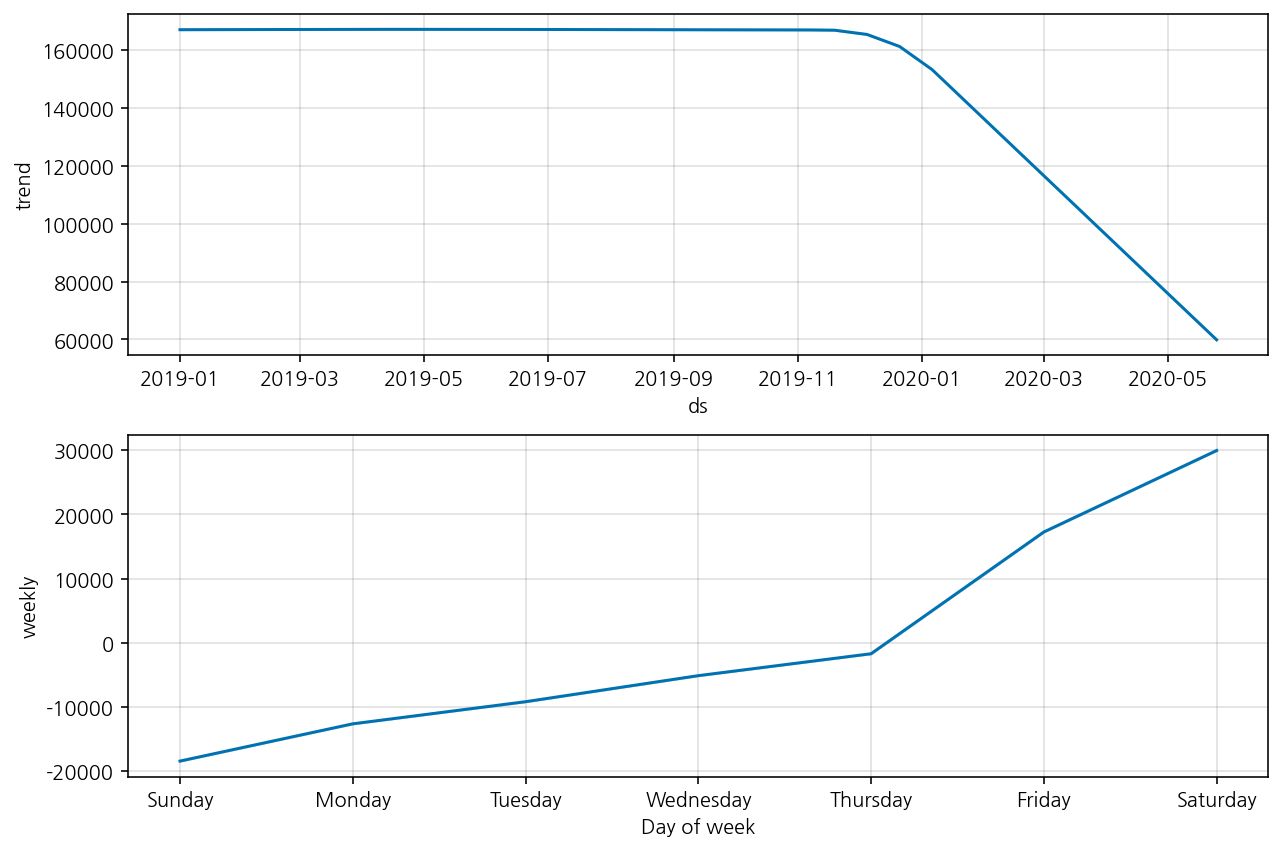

In [30]:
fig2 = prophet_model.plot_components(forecast)

In [58]:
for i in weather_add_covid.역명.unique():
  df_set = weather_add_covid[weather_add_covid.역명 == i]
  size = int(len(df_set) * 0.8)
  train = df_set[:size]
  test = df_set[size:]
  # prophet은 ds와 y 두 개의 column으로만 진행
  df_prophet = pd.DataFrame({'ds' : train.일시, 'y' : train.승하차인원}).reset_index(drop=True) 
  prophet_model = Prophet() # 예측값에 상한과 하한을 두지 않을 것이기 때문에 'logistic' 등을 사용하지 않고 default인 'linear' 사용
  result = prophet_model.fit(df_prophet)
  prophet_test = pd.DataFrame(test.일시).rename(columns={'일시' : 'ds'})
  prophet_pred_df = result.predict(prophet_test)
  prophet_pred = prophet_pred_df.yhat
  print("Mean value of 역명 {} :".format(i), df_set.승하차인원.mean())
  print("역명 {} MAE Score of test :".format(i), mae(test.승하차인원, prophet_pred))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean value of 역명 1 : 188024.93055555556
역명 1 MAE Score of test : 54040.20174944342


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean value of 역명 2 : 108398.92857142857
역명 2 MAE Score of test : 41090.70306699975


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean value of 역명 3 : 155583.5515873016
역명 3 MAE Score of test : 49549.92762771833


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean value of 역명 4 : 151064.60515873015
역명 4 MAE Score of test : 61468.105255025264


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean value of 역명 5 : 85433.3253968254
역명 5 MAE Score of test : 19862.8319502007


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean value of 역명 6 : 31289.059523809523
역명 6 MAE Score of test : 9235.155059067345


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean value of 역명 7 : 68663.45238095238
역명 7 MAE Score of test : 24875.157017317968
Mean value of 역명 8 : 22040.849206349205
역명 8 MAE Score of test : 9966.548103677265


In [56]:
for i in weather_add_covid.역명.unique():
  df_set = weather_add_covid[weather_add_covid.역명 == i]
  # prophet은 ds와 y 두 개의 column으로만 진행
  df_prophet = pd.DataFrame({'ds' : df_set.일시, 'y' : df_set.승하차인원}).reset_index(drop=True) 
  prophet_model = Prophet() # 예측값에 상한과 하한을 두지 않을 것이기 때문에 'logistic' 등을 사용하지 않고 default인 'linear' 사용
  result = prophet_model.fit(df_prophet)
  prophet_test = pd.DataFrame(df_set.일시).rename(columns={'일시' : 'ds'})
  prophet_pred_df = result.predict(prophet_test)
  prophet_pred = prophet_pred_df.yhat
  print("Mean value of 역명 {} :".format(i), df_set.승하차인원.mean())
  print("역명 {} MAE Score of test :".format(i), mae(df_set.승하차인원, prophet_pred))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean value of 역명 1 : 188024.93055555556
역명 1 MAE Score of test : 18298.292407473367


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean value of 역명 2 : 108398.92857142857
역명 2 MAE Score of test : 10709.118106379703


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean value of 역명 3 : 155583.5515873016
역명 3 MAE Score of test : 13134.007348637955


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean value of 역명 4 : 151064.60515873015
역명 4 MAE Score of test : 13013.468336990432


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean value of 역명 5 : 85433.3253968254
역명 5 MAE Score of test : 6290.830490822773


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean value of 역명 6 : 31289.059523809523
역명 6 MAE Score of test : 3309.8965691739236


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean value of 역명 7 : 68663.45238095238
역명 7 MAE Score of test : 5890.092060703319
Mean value of 역명 8 : 22040.849206349205
역명 8 MAE Score of test : 6369.084176845054
